Image segmentation models separate areas corresponding to different areas of interest in an image. These models work by assigning a label to each pixel. There are several types of segmentation: semantic segmentation, instance segmentation, and panoptic segmentation.

In this guide, we will:

1. Take a look at different types of segmentation.
2. Have an end-to-end fine-tuning example for semantic segmentation.

# Libraries

In [1]:
pip install -q datasets transformers evaluate accelerate

Note: you may need to restart the kernel to use updated packages.


In [2]:

import json
import requests
from PIL import Image
from transformers import pipeline
from datasets import load_dataset
from huggingface_hub import cached_download, hf_hub_url

2024-07-01 17:00:37.490850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Types of Segmentation

## Semantic Segmentation

Semantic segmentation assigns a label or class to every single pixel in an image. If we were to take a look at a semantic segmentation model output, it will assign the same class to every instance of an object it comes across in an image. For example, all cats will be labeled as “cat” instead of “cat-1”, “cat-2”. We can use transformers’ image segmentation pipeline to quickly infer a semantic segmentation model. Let’s take a look at the example image.

The model we will use is NVIDIA'S SegFormer: nvidia/segformer-b1-finetuned-cityscapes-1024-1024.

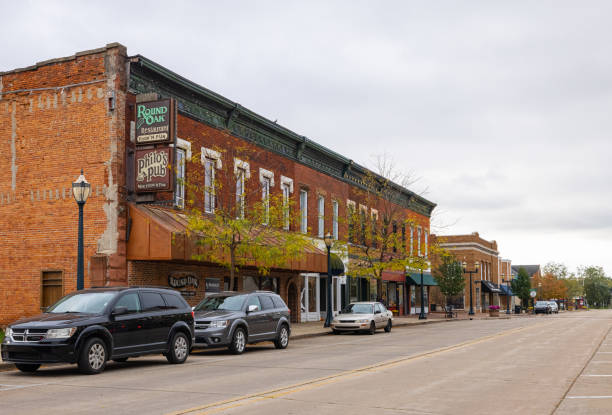

In [3]:
# Get the image
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/segmentation_input.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [4]:
# Get segmentation pipeline output results
semantic_segmentation = pipeline("image-segmentation", "nvidia/segformer-b1-finetuned-cityscapes-1024-1024")
results = semantic_segmentation(image)
results

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/Users/nm/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


[{'score': None,
  'label': 'road',
  'mask': <PIL.Image.Image image mode=L size=612x415>},
 {'score': None,
  'label': 'sidewalk',
  'mask': <PIL.Image.Image image mode=L size=612x415>},
 {'score': None,
  'label': 'building',
  'mask': <PIL.Image.Image image mode=L size=612x415>},
 {'score': None,
  'label': 'wall',
  'mask': <PIL.Image.Image image mode=L size=612x415>},
 {'score': None,
  'label': 'pole',
  'mask': <PIL.Image.Image image mode=L size=612x415>},
 {'score': None,
  'label': 'traffic sign',
  'mask': <PIL.Image.Image image mode=L size=612x415>},
 {'score': None,
  'label': 'vegetation',
  'mask': <PIL.Image.Image image mode=L size=612x415>},
 {'score': None,
  'label': 'terrain',
  'mask': <PIL.Image.Image image mode=L size=612x415>},
 {'score': None,
  'label': 'sky',
  'mask': <PIL.Image.Image image mode=L size=612x415>},
 {'score': None,
  'label': 'car',
  'mask': <PIL.Image.Image image mode=L size=612x415>}]

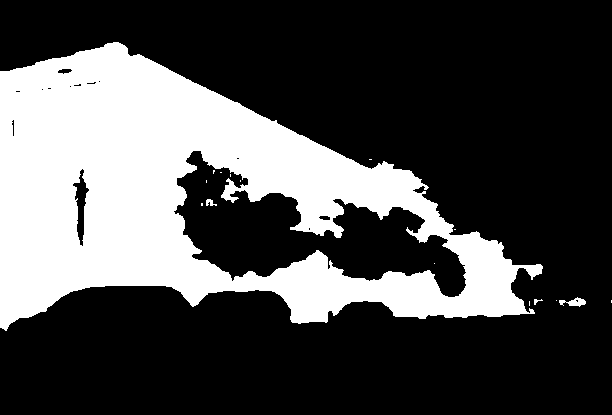

In [5]:
# Taking a look at the mask for the building class, we can see every building is classified with the same mask.
labels = [seg_dict['label'] for seg_dict in results]
required_label = 'building'
results[labels.index(required_label)]["mask"]

## Instance Segmentation

In instance segmentation, the goal is not to classify every pixel, but to predict a mask for every instance of an object in a given image. It works very similar to object detection, where there is a bounding box for every instance, there’s a segmentation mask instead. 

We will use Facebook's facebook/mask2former-swin-large-cityscapes-instance for this.

In [6]:
instance_segmentation = pipeline("image-segmentation", "facebook/mask2former-swin-large-cityscapes-instance")
results = instance_segmentation(image)
results

`label_ids_to_fuse` unset. No instance will be fused.


[{'score': 0.999944,
  'label': 'car',
  'mask': <PIL.Image.Image image mode=L size=612x415>},
 {'score': 0.999945,
  'label': 'car',
  'mask': <PIL.Image.Image image mode=L size=612x415>},
 {'score': 0.999652,
  'label': 'car',
  'mask': <PIL.Image.Image image mode=L size=612x415>},
 {'score': 0.903532,
  'label': 'person',
  'mask': <PIL.Image.Image image mode=L size=612x415>}]

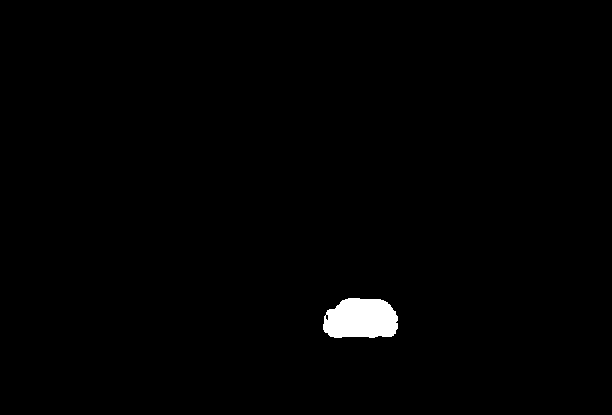

In [7]:
# Check out one of the car instances
results[2]["mask"]

## Panoptic Segmentation

Panoptic segmentation combines semantic segmentation and instance segmentation, where every pixel is classified into a class and an instance of that class, and there are multiple masks for each instance of a class. We'll use Facebook's facebook/mask2former-swin-large-cityscapes-panoptic for panoptic segmentation.

In [8]:
panoptic_segmentation = pipeline("image-segmentation", "facebook/mask2former-swin-large-cityscapes-panoptic")
results = panoptic_segmentation(image)

# Result show we have more classes. 
# We will later illustrate to see that every pixel is classified into one of the classes.
results

`label_ids_to_fuse` unset. No instance will be fused.


[{'score': 0.999981,
  'label': 'car',
  'mask': <PIL.Image.Image image mode=L size=612x415>},
 {'score': 0.999958,
  'label': 'car',
  'mask': <PIL.Image.Image image mode=L size=612x415>},
 {'score': 0.99997,
  'label': 'vegetation',
  'mask': <PIL.Image.Image image mode=L size=612x415>},
 {'score': 0.999575,
  'label': 'pole',
  'mask': <PIL.Image.Image image mode=L size=612x415>},
 {'score': 0.999958,
  'label': 'building',
  'mask': <PIL.Image.Image image mode=L size=612x415>},
 {'score': 0.999634,
  'label': 'road',
  'mask': <PIL.Image.Image image mode=L size=612x415>},
 {'score': 0.996092,
  'label': 'sidewalk',
  'mask': <PIL.Image.Image image mode=L size=612x415>},
 {'score': 0.999221,
  'label': 'car',
  'mask': <PIL.Image.Image image mode=L size=612x415>},
 {'score': 0.99987,
  'label': 'sky',
  'mask': <PIL.Image.Image image mode=L size=612x415>}]

# Fine-tuning a model for Semantic Segmentation

Seeing all types of segmentation, let’s have a deep dive on fine-tuning a model for semantic segmentation. We will now:

a. Finetune SegFormer on the SceneParse150 dataset.<br>
b. Use the fine-tuned model for inference.

Common real-world applications of semantic segmentation include training self-driving cars to identify pedestrians and important traffic information, identifying cells and abnormalities in medical imagery, and monitoring environmental changes from satellite imagery.

In [9]:
# Load SceneParse150 dataset
ds = load_dataset("scene_parse_150", split="train[:50]") # Load subset first, for experimentation

ds = ds.train_test_split(test_size=0.2)
train_ds = ds["train"]
test_ds = ds["test"]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20210 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3352 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [10]:
# Inspect the data set
# image: a PIL image of the scene.
# annotation: a PIL image of the segmentation map, which is also the model’s target.
# scene_category: a category id that describes the image scene like “kitchen” or “office”.
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>,
 'annotation': <PIL.PngImagePlugin.PngImageFile image mode=L size=640x480>,
 'scene_category': 129}

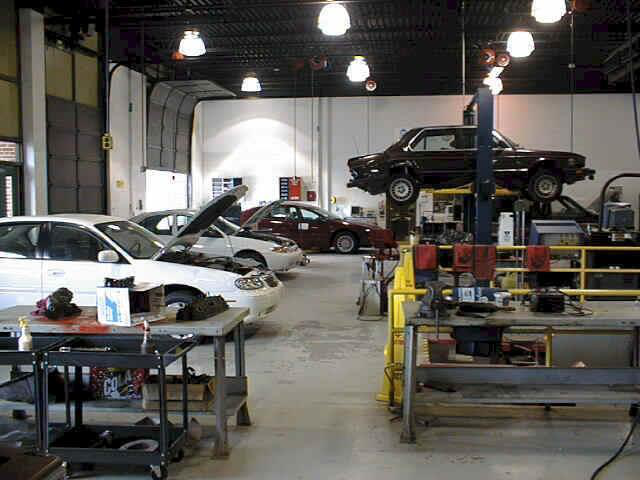

In [11]:
# In this guide, you’ll only need image and annotation, both of which are PIL images.
train_ds[0]["image"]

In [12]:
# Create a dictionary that maps a label id to a label class
# Download the mappings from the Hub and create the id2label and label2id dictionaries:
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(cached_download(hf_hub_url(repo_id, filename, repo_type="dataset")), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

## Using the model on a custom dataset
